In [1]:
from __future__ import print_function
import csv
import math
import sys
import cv2
import os
from sklearn.metrics import f1_score
from pathlib import Path
from keras import optimizers
import numpy as np
from keras.models import load_model
import time
from unet import *
from data import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger
import keras.backend as K
K.set_image_data_format('channels_last')

In [2]:
def recall_m(y_true, y_pred):
    y_pred = K.reshape(y_pred, shape=(
        (K.shape(y_pred)[0]*K.shape(y_pred)[1]*K.shape(y_pred)[2]), num_classes))
    y_true = K.reshape(y_true, shape=(
        (K.shape(y_true)[0]*K.shape(y_true)[1]*K.shape(y_true)[2]), num_classes))
    # without background. Last class should be background
    true_positives = K.sum(
        K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)[0:-1])
    # without background. Last class should be background
    possible_positives = K.sum(
        K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)[0:-1])
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    y_pred = K.reshape(y_pred, shape=(
        (K.shape(y_pred)[0]*K.shape(y_pred)[1]*K.shape(y_pred)[2]), num_classes))
    y_true = K.reshape(y_true, shape=(
        (K.shape(y_true)[0]*K.shape(y_true)[1]*K.shape(y_true)[2]), num_classes))
    # without background. Last class should be background
    true_positives = K.sum(
        K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)[0:-1])
    # without background. Last class should be background
    predicted_positives = K.sum(
        K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)[0:-1])
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def fscore(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall + K.epsilon()))


def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


def fscore1(y_true, y_pred):
    y_true = y_true[:, :, :, :-1]
    y_pred = y_pred[:, :, :, :-1]
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(y_pred))
    possible_positives = K.sum(K.round(y_true))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f_score1 = 2*((precision*recall)/(precision+recall + K.epsilon()))
    return f_score1

/Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification
hello train name /Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification/data_keras/train
['.DS_Store', 'images', 'mask']
['.DS_Store', '21_training.png']
brrr



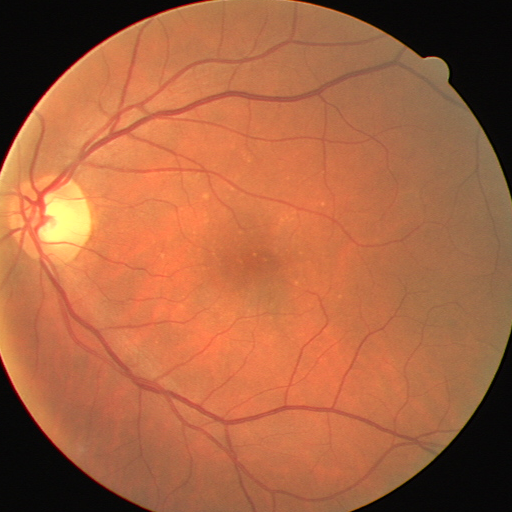


/Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification/data_keras/train
Found 1 images belonging to 1 classes.


In [3]:
data_gen_train = dict(rotation_range=10,
                      horizontal_flip=True,
                      width_shift_range=5,
                      height_shift_range=5,
                      vertical_flip=True,
                      fill_mode='nearest')

path =os.getcwd()

path = Path(path)

print(path)


# path1 = Path("/mnt/smiledata/shajahan_trails/Weights")
path1 = Path("/Weights")


magnification = "4x"
if sys.argv[1:]:
    magnification = sys.argv[1]

# val_name = path/"Data_keras"/magnification/"val"
# train_name = path/"Data_keras"/magnification/"train"
# csv_name = path/"Results/CSV"/magnification/"training_4x.csv"
# weights_folder = path1/magnification/"weights"
# model_name = path/"Modelh5/core_model.h5"

val_name = path/"data_keras/val/"
train_name = path/"data_keras/train/"
csv_name = "Results/CSV/training_4x.csv"
weights_folder = path/"Weights/4x/weights"
model_name = "Modelh5/core_model.h5"


batch_size = 4  # No. of images in a batch
size = 512
# weights_40x = [0.979, 0.947, 0.929, 0.982, 0.164]
# weights_10x = [0.967, 0.96, 0.88, 0.974, 0.219]

# weights_4x = {0:0.967, 1:0.969, 2:0.887, 3:0.969, 4:0.208}


# weights = weights_4x

print("hello train name",train_name)


print(os.listdir(train_name))

from IPython.display import Image, display

listOfImageNames = os.listdir(train_name/"images")
print(listOfImageNames)

i =0
for imageName in listOfImageNames:
    if i ==0:
        print("brrr")
        print()

    else:
        display(Image(filename=train_name/"images"/imageName))
        print()

    i= i+1
    # print(i)

print(train_name)
num_images = num_of_images(train_name)


In [4]:
# val_x, val_y, img_name = validation(
#     str(val_name/"images"), str(val_name/"mask")) i commentd



# display(Image(filename=val_name/"images/32_manual1.png"))

val_x, val_y, img_name = validation(
    str(val_name/"images"), str(val_name/"mask"))




train = dataGenerator(batch_size, train_name, data_gen_train, size)
loss_fn = 'categorical_crossentropy'
batch_steps = np.ceil(num_images / batch_size)
sgd = optimizers.SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True)
rms = optimizers.RMSprop(lr=1e-4)
#opt = 'adam'
opt = rms

if os.path.isdir(weights_folder) is not True:
    os.mkdir(weights_folder)

csv_logger = CSVLogger(csv_name, append=True)
# ,save_best_only=True,monitor='val_fscore',mode='max')
checkpointer = ModelCheckpoint(
    filepath='%s/weights.{epoch:03d}.hdf5' % weights_folder, save_weights_only=True) 
start = time.time()


checkpoint_path = str(model_name)

# checkpoint_path = None

if checkpoint_path is not None:
    model = load_model(checkpoint_path, custom_objects={'fscore': fscore})
    # To continue from a particular epoch
    model.load_weights("%s/weights.005.hdf5" % str(weights_folder)) 
    initial_epoch = 5
else:
    model = build_model(input_shape=(None, None, 3),
                        preset_model="MobileUNet-Skip", num_classes=num_classes)
    initial_epoch = 0

final_epoch = 9
print(model.summary())
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', fscore])

# model.fit_generator(train, steps_per_epoch=batch_steps, epochs=final_epoch, verbose=1, validation_data=(
#     val_x, val_y), validation_steps=None,  callbacks=[csv_logger, checkpointer], shuffle=True, class_weight=weights, initial_epoch=initial_epoch)
# i commeted

model.fit(train, steps_per_epoch=batch_steps, epochs=final_epoch, verbose=1, validation_data=(
    val_x, val_y), validation_steps=None,callbacks=[csv_logger, checkpointer], shuffle=True, class_weight=None, initial_epoch=initial_epoch)


model.save(str(model_name))
end = time.time()
print(
    f"time taken for training {final_epoch - initial_epoch} is {end - start} seconds")


['/Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification/data_keras/val/images/21_manual1.png']


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "MobileUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['zero_padding2d[0][0]']         
                                64)                                                      

2022-06-13 11:27:16.023174: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 8s 8s/step - loss: 0.4718 - accuracy: 0.6384 - fscore: 0.0000e+00 - val_loss: 0.5800 - val_accuracy: 0.8395 - val_fscore: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 0.3614 - accuracy: 0.8256 - fscore: 0.0000e+00 - val_loss: 0.5786 - val_accuracy: 0.8395 - val_fscore: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.3175 - accuracy: 0.8736 - fscore: 0.0000e+00 - val_loss: 0.5772 - val_accuracy: 0.8395 - val_fscore: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.2958 - accuracy: 0.8970 - fscore: 0.0000e+00 - val_loss: 0.5759 - val_accuracy: 0.8395 - val_fscore: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.2694 - accuracy: 0.9196 - fscore: 0.0000e+00 - val_loss: 0.5748 - val_accuracy: 0.8395 - val_fscore: 0.0000e+00
time taken for training 5 is 23.384212017059326 seconds
